In [1]:
import pandas as pd
import numpy as np
import skbio

In [2]:
mci_consensus_cluster = pd.read_csv("/home/bruce1996/data/MCI/manuscript_v3/MCI/consensus/mixed_clustering_without_rogosae.txt",sep='\t')
normal_consensus_cluster = pd.read_csv("/home/bruce1996/data/MCI/manuscript_v3/normal/consensus/mixed_clustering_without_rogosae.txt",sep='\t')

### alpha diversity

In [3]:
class alpha_diversity :
    def __init__(self,abundance_table,method_list) :
        if isinstance(abundance_table,pd.DataFrame) == False :
            raise TypeError("Abundance table must be pandas dataframe !")
        if isinstance(method_list,list) == False :
            raise TypeError("Method list must be list contain str like ['Chao1','ACE','Fisher','Simpson']!")
        self.abundance_table = abundance_table
        self.sample = abundance_table.columns
        self.method = method_list
        self.alpha_diversity = np.zeros([len(self.sample),len(method_list)])

    def calculate_alpha_diversity(self,method) :
        alpha_diversity = np.zeros(len(self.sample))
        for idx in range(len(self.sample)) :
            if method == 'Shannon' :
                alpha_diversity[idx] = skbio.diversity.alpha.shannon(self.abundance_table.iloc[:,idx].values) # type: ignore
            elif method == 'Simpson' :
                alpha_diversity[idx] = skbio.diversity.alpha.simpson(self.abundance_table.iloc[:,idx].values) # type: ignore
            elif method == 'Fisher' :
                alpha_diversity[idx] = skbio.diversity.alpha.fisher_alpha(self.abundance_table.iloc[:,idx].values) # type: ignore
            elif method == 'Chao1' :
                alpha_diversity[idx] = skbio.diversity.alpha.chao1(self.abundance_table.iloc[:,idx].values) # type: ignore
            elif method == 'ACE' :
                alpha_diversity[idx] = skbio.diversity.alpha.ace(self.abundance_table.iloc[:,idx].values) # type: ignore
        return alpha_diversity
    
    def calculate_alpha(self) :
        for idx,method in enumerate(self.method) :
            self.alpha_diversity[:,idx] = self.calculate_alpha_diversity(method)
        alpha_df = pd.DataFrame(self.alpha_diversity,index=self.sample,columns=self.method)
        return alpha_df

In [4]:
metaphlan = pd.read_csv("/home/bruce1996/data/MCI/metaphlan_result/metaphlan_format_table.txt",sep='\t',index_col=0)
metadata = pd.read_csv("/home/bruce1996/data/MCI/metadata/metadata_20221224.csv",sep=',',index_col=0)
metaphlan = metaphlan * 10 ** 6 
for c in metaphlan.columns :
    metaphlan[c] = metaphlan[c].fillna(0.0).astype(int)

In [7]:
import re
probiotic_idx = [bool(re.search("Lactobacillus|Bifidobacterium",x)) for x in metaphlan.index]
probiotic_matrix = metaphlan.loc[probiotic_idx,:]

### visualization of alpha diversity

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums

In [11]:
meta_alpha = alpha_diversity(probiotic_matrix,method_list=['Shannon','Simpson','Fisher','Chao1'])
alpha_df = meta_alpha.calculate_alpha()

/home/bruce1996/anaconda3/lib/python3.9/site-packages/skbio/diversity/alpha/_base.py:869: RuntimeWarning: invalid value encountered in true_divide
  freqs = counts / counts.sum()
/home/bruce1996/anaconda3/lib/python3.9/site-packages/skbio/diversity/alpha/_base.py:138: RuntimeWarning: invalid value encountered in true_divide
  freqs = counts / counts.sum()


In [12]:
mci_alpha = pd.concat([alpha_df.loc[mci_consensus_cluster.index,:],mci_consensus_cluster],axis=1).melt(id_vars='cluster')
mci_alpha.columns = ["Cluster",'Measurement','value']
normal_alpha = pd.concat([alpha_df.loc[normal_consensus_cluster.index,:],normal_consensus_cluster],axis=1).melt(id_vars='cluster')
normal_alpha.columns = ["Cluster",'Measurement','value']

In [13]:
#Calculate significant for each cluster pair
measure_dict = {}
alpha_diversity_df = normal_alpha
for measure in ['Shannon','Simpson','Fisher','Chao1','ACE'] :
    measure_dict[measure] = []
    for i in range(1,5) :
        for j in range(i,5) :
            c1_idx = np.where((alpha_diversity_df['Measurement'] == measure) & (alpha_diversity_df['Cluster'] == i),True,False)
            m_c1 = alpha_diversity_df.loc[c1_idx,"value"].values
            c2_idx = np.where((alpha_diversity_df['Measurement'] == measure) & (alpha_diversity_df['Cluster'] == j),True,False)
            m_c2 = alpha_diversity_df.loc[c2_idx,"value"].values
            pval = ranksums(m_c1,m_c2)[1]
            if pval < 0.1 :
                measure_dict[measure].append( (i,j,round(pval,4)))


/home/bruce1996/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:7784: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


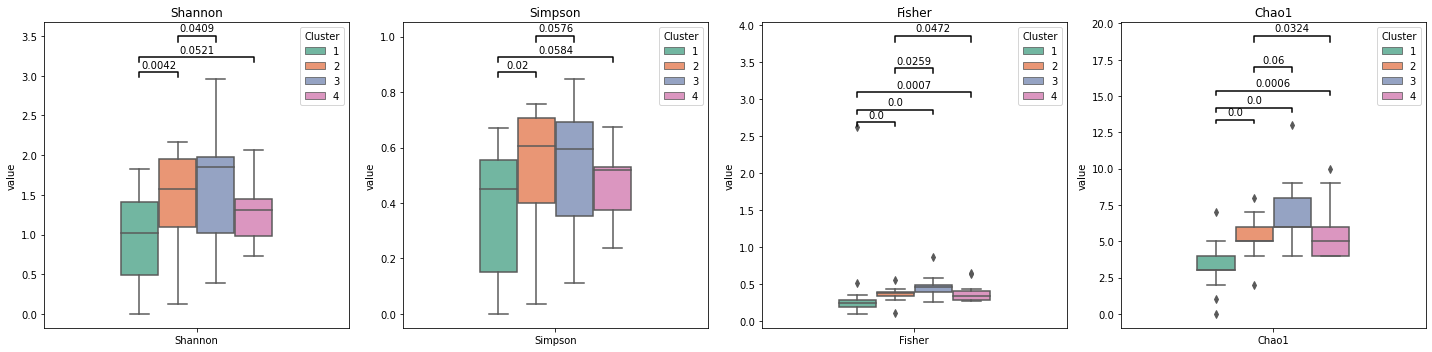

In [17]:
fig, axes = plt.subplots(1, 4,figsize=(20,5))
anno_xaxis = {1:-0.3,2:-0.1,3:0.1,4:0.3}
alpha_diversity_df = mci_alpha
measurements = ['Shannon','Simpson','Fisher','Chao1']
for idx,ax in enumerate(axes.ravel()) :
    plot_df = alpha_diversity_df.loc[alpha_diversity_df['Measurement'] == measurements[idx],:]
    axs = sns.boxplot(data=plot_df,x='Measurement',y='value',hue='Cluster',palette="Set2",ax=ax)
    if measure_dict[measurements[idx]] != [] :
        y, col = plot_df['value'].max() * 0.97, 'k'
        n = 1
        for c1,c2,pval in measure_dict[measurements[idx]] :
            n+= 1
            y *= (1.02 ** n)
            c1_x,c2_x = anno_xaxis[c1],anno_xaxis[c2]
            xaxis = (c1_x+c2_x) / 2
            axs.plot([c1_x, c1_x, c2_x, c2_x], [y, y*1.02, y*1.02, y], lw=1.5, c=col)
            axs.text(xaxis, y*1.03, str(pval), ha='center', va='bottom', color=col)
    axs.set_title("%s" % measurements[idx])
    axs.set(xlabel=None)
plt.tight_layout()
plt.savefig("/home/bruce1996/data/MCI/manuscript_v3/supplement/probiotics_only_diversity/alpha_diversity/MCI_alpha_diversity_boxplot.png",dpi=300,bbox_inches='tight')


### Relevant taxon-based methods

Pesudo code of relevant taxon-based methods :
1. Define enriched & depleted taxonomy in reference sample set and target sample set (via LefSe)
2. Calculate dysbiosis index by following equalation :
$$\mathrm{DysbiosisIndex} = \frac{\sum_{i=1}^{n}{abundance(EnrichTaxa)_i}}{\sum_{i=1}^{n}{abundance(DepletedTaxa)_i}}$$

In [6]:
metaphlan = pd.read_csv("/home/bruce1996/data/MCI/metaphlan_result/metaphlan_format_table.txt",sep='\t',index_col=0)
metadata = pd.read_csv("/home/bruce1996/data/MCI/metadata/metadata_20221224.csv",sep=',',index_col=0)
metaphlan = metaphlan.loc[:,metadata.index]

In [7]:
lefse_res = pd.read_csv("/home/bruce1996/data/MCI/manuscript_v3/supplement/alpha_diversity/normal_mci_lefse.res",sep='\t',header=None,index_col=0)

In [8]:
lefse_res.columns = ['wilconox','class','LDA_score','kw']# type: ignore
lefse_res = lefse_res.fillna(-1)
selected_species = list(lefse_res.index[lefse_res['LDA_score'] != -1])

In [9]:
depleted_taxa = ['s__Parabacteroides_distasonis']
enriched_taxa = selected_species[:]
enriched_taxa.remove('s__Parabacteroides_distasonis')

In [10]:
dysbiosis_score = metaphlan.loc[enriched_taxa,:].sum() / metaphlan.loc[depleted_taxa,:].sum()

### Neighborhood classification
Pesudo code of Neighborhood classification :
1. Calculate median Bray-Curtis distance between sample & reference sample set(normal).
2. 90th percentile of dysbiosis score in reference sample set is threshold for dysbiosis.

In [103]:
from skbio.diversity import beta_diversity

In [104]:
def dysbiosis_score_by_neighborhood(abundance_table,label_series,reference_prefix='Normal') :
    '''
    abundance_table : pd.DataFrame, row is taxa , columns is sample
    label_series : pd.Series
    reference_prefix : str, represent reference in label_series
    '''
    abundance_table = abundance_table.loc[:,label_series.index]
    bray_curtis_dis = beta_diversity("braycurtis", abundance_table.T, list(abundance_table.columns))
    reference_idx = np.where(label_series == reference_prefix,True,False)
    #calculate each sample median Bray-Curtis distance to reference sample set
    bray_curtis_median = np.zeros(abundance_table.shape[1])
    for sample_idx,sample in enumerate(abundance_table.columns) :
        bray_curtis_median[sample_idx] = np.median(bray_curtis_dis[sample][reference_idx])
    #Normalize Bray-Curtis distance median by threshold, threhold = 1 other = original_score / threshold
    threshold = np.percentile(bray_curtis_median[reference_idx],90)
    dysbiosis_score = bray_curtis_median / threshold
    return dysbiosis_score


In [113]:
dysbiosis_score_neighbor = dysbiosis_score_by_neighborhood(metaphlan.loc[:,metadata.index],metadata['Diagnosis'])
dysbiosis_score_neighbor = pd.Series(dysbiosis_score_neighbor,index=metadata.index)

### Combined alpha and beta diversity
Pesudo code for combined alpha and beta diversity
1. Calculate shannon index and jensenshannon divergence.
2. Dysbiosis index is defined by following equation :
$$\mathrm{DysbiosisIndex} = {(AverageShannonIndexDifference)_i} \times {(AverageJensenShannonDivergence)_i}

In [108]:
from scipy.spatial import distance

In [109]:
def alpha_beta_dysbiosis_score(abundance_table,label_series,reference_prefix='Normal') :
    '''
    abundance_table : pd.DataFrame, metaphlan formated output
    metadata : pd.Series, clinical information of samples
    reference_prefix : str, represent sample is reference
    '''
    target_sample = list(metadata.index[label_series != reference_prefix])
    normal_sample = list(metadata.index[label_series == reference_prefix])
    shannon = np.zeros(abundance_table.shape[1])
    #calculate shannon index for all sample
    for idx in range(abundance_table.shape[1]) :
        shannon[idx] = skbio.diversity.alpha.shannon(abundance_table.iloc[:,idx].values) # type: ignore
    shannon_difference = np.zeros(len(target_sample))
    #calculate average shannon index difference between sample & reference sample set
    shannon = pd.Series(shannon,index=abundance_table.columns)
    for shannon_idx,sample in enumerate(target_sample) :
        shannon_array = np.zeros(len(normal_sample))
        for idx,reference in enumerate(normal_sample) :
            shannon_array[idx] = abs(shannon[sample] - shannon[reference])
        shannon_difference[shannon_idx] = np.mean(shannon_array)
    #calculate jensen shannon divergence of target sample
    target_jsd = np.zeros(len(target_sample))
    for jsd_idx,sample in enumerate(target_sample) :
        jsd_array = np.zeros(len(normal_sample))
        for idx,reference in enumerate(normal_sample) :
            target_val = metaphlan.loc[:,sample].values
            ref_val = metaphlan.loc[:,reference].values
            jsd_array[idx] = distance.jensenshannon(target_val,ref_val) ** 2
        target_jsd[jsd_idx] = np.mean(jsd_array)
    
    dysbiosis_score = shannon_difference * target_jsd
    return dysbiosis_score


In [121]:
dysbiosis_combination = alpha_beta_dysbiosis_score(metaphlan,metadata['Diagnosis'])
target_sample = list(metadata.index[metadata['Diagnosis'] != 'Normal'])
dysbiosis_combination = pd.Series(dysbiosis_combination,index=target_sample)

### Dysbiosis score between cluster

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums

In [ ]:
mci_consensus_cluster = pd.read_csv("/home/bruce1996/data/MCI/manuscript_v3/MCI/consensus/mixed_clustering_without_rogosae.txt",sep='\t')

dysbiosis_score_df = pd.DataFrame({'Relavent_taxa' : dysbiosis_score[target_sample],
                                   "Neighborhood_classification" : dysbiosis_score_neighbor[target_sample],
                                   "Alpha_beta_combination" : dysbiosis_combination})
dysbiosis_score_df['Cluster'] = mci_consensus_cluster['cluster'][target_sample]

In [133]:
dysbiosis_score_melt = dysbiosis_score_df.melt(id_vars='Cluster')
dysbiosis_score_melt.columns = ["Cluster","Measurement","value"]

In [138]:
#Calculate significant for each cluster pair
dysbiosis_score_melt = dysbiosis_score_df.melt(id_vars='Cluster')
dysbiosis_score_melt.columns = ["Cluster","Measurement","value"]


measure_dict = {}
alpha_diversity_df = dysbiosis_score_melt
measurement = list(dysbiosis_score_df.columns)
measurement.remove("Cluster")
for measure in measurement :
    measure_dict[measure] = []
    for i in range(1,5) :
        for j in range(i,5) :
            c1_idx = np.where((alpha_diversity_df['Measurement'] == measure) & (alpha_diversity_df['Cluster'] == i),True,False)
            m_c1 = alpha_diversity_df.loc[c1_idx,"value"].values
            c2_idx = np.where((alpha_diversity_df['Measurement'] == measure) & (alpha_diversity_df['Cluster'] == j),True,False)
            m_c2 = alpha_diversity_df.loc[c2_idx,"value"].values
            pval = ranksums(m_c1,m_c2)[1]
            if pval < 0.1 :
                measure_dict[measure].append( (i,j,round(pval,4)))


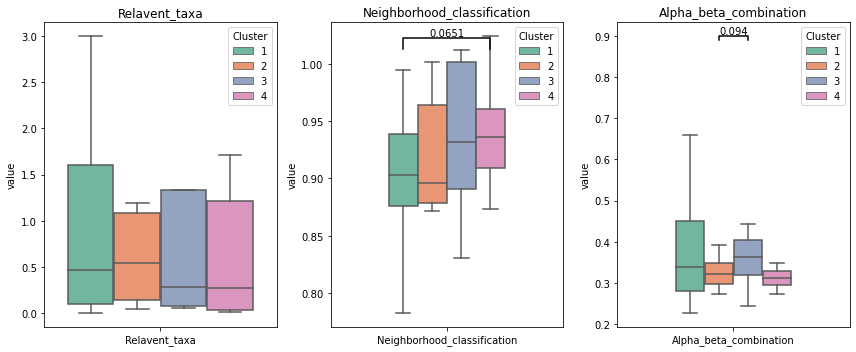

In [152]:
fig, axes = plt.subplots(1, 3,figsize=(12,5))
anno_xaxis = {1:-0.3,2:-0.1,3:0.1,4:0.3}
alpha_diversity_df = dysbiosis_score_melt
measurements = measurement
for idx,ax in enumerate(axes.ravel()) :
    plot_df = alpha_diversity_df.loc[alpha_diversity_df['Measurement'] == measurements[idx],:]
    axs = sns.boxplot(data=plot_df,x='Measurement',y='value',hue='Cluster',palette="Set2",ax=ax,showfliers=False)
    if measure_dict[measurements[idx]] != [] :
        y, col = plot_df['value'].max() * 0.92, 'k'
        n = -1
        for c1,c2,pval in measure_dict[measurements[idx]] :
            n+=1
            y *= (1.02 ** n)
            c1_x,c2_x = anno_xaxis[c1],anno_xaxis[c2]
            xaxis = (c1_x+c2_x) / 2
            axs.plot([c1_x, c1_x, c2_x, c2_x], [y, y*1.01, y*1.01, y], lw=1.5, c=col)
            axs.text(xaxis, y*1.01, str(pval), ha='center', va='bottom', color=col)
    axs.set_title("%s" % measurements[idx])
    axs.set(xlabel=None)
plt.tight_layout()
plt.savefig("/home/bruce1996/data/MCI/manuscript_v3/MCI/alpha_diversity/dysbiosis_score_boxplot.png",dpi=300,bbox_inches='tight')


In [148]:
y

0.9386093208064976